In [3]:
import os
import zipfile
import numpy as np
from helpers import load_csv_data  # Make sure load_csv_data function is defined in helpers.py


In [4]:

# Define data path
data_path = "data/dataset"
# Load data
column_names,x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

# Confirm data loading success
print("Data loaded successfully")

# Print first 10 rows of data
print("First 10 labels of y_train:")
print(y_train[:10])

print("\nFirst 10 rows of x_train:")
print(x_train[:10])

print("\nFirst 10 IDs of test_ids:")
print(test_ids[:10])

columns_to_drop = ['FMONTH','IDATE','IMONTH','IDAY','IYEAR','DISPCODE','SEQNO','_PSU','CTELNUM1','CELLFON2','LANDLINE','NUMHHOL2','NUMPHON2','CPDEMO1','WHRTST10','_CLLCPWT','_DUALUSE','_DUALCOR','_LLCPWT','FVBEANS', 'FVGREEN','FVORANG','VEGETAB1','STRENGTH','QSTLANG','_STSTR','_STRWT','_RAWRAKE' ,'_WT2RAKE']
indices_to_drop = [i for i, col in enumerate(column_names[1:]) if col in columns_to_drop]
# Delete specified columns

x_train = np.delete(x_train, indices_to_drop, axis=1)        
# Output the first 10 rows of x_train after deletion
print("\n=== First 10 rows of x_train after deletion ===")   
print(x_train[:10])   

Data loaded successfully
First 10 labels of y_train:
[-1 -1 -1 -1 -1 -1  1  1 -1 -1]

First 10 rows of x_train:
[[5.3000000e+01 1.1000000e+01 1.1162015e+07 ...           nan
            nan 2.0000000e+00]
 [3.3000000e+01 1.2000000e+01 1.2152015e+07 ...           nan
            nan           nan]
 [2.0000000e+01 1.0000000e+01 1.0202015e+07 ... 1.0000000e+00
  2.0000000e+00 2.0000000e+00]
 ...
 [4.4000000e+01 3.0000000e+00 3.0720150e+06 ... 1.0000000e+00
  2.0000000e+00 2.0000000e+00]
 [2.1000000e+01 7.0000000e+00 7.3120150e+06 ...           nan
            nan 2.0000000e+00]
 [4.0000000e+00 6.0000000e+00 6.2320150e+06 ...           nan
            nan           nan]]

First 10 IDs of test_ids:
[328135 328136 328137 328138 328139 328140 328141 328142 328143 328144]

=== First 10 rows of x_train after deletion ===
[[53. nan nan ... nan nan  2.]
 [33.  1.  1. ... nan nan nan]
 [20.  1.  1. ...  1.  2.  2.]
 ...
 [44.  1.  1. ...  1.  2.  2.]
 [21. nan nan ... nan nan  2.]
 [ 4. nan nan ..

In [5]:
column_names.remove('Id')
new_column_names = [col for i, col in enumerate(column_names) if i not in indices_to_drop]
print(f"Number of new column names: {len(new_column_names)}")
print(f"Preview of new column names: {new_column_names[:5]} ...")

Number of new column names: 292
Preview of new column names: ['_STATE', 'CTELENUM', 'PVTRESD1', 'COLGHOUS', 'STATERES'] ...


In [6]:
# x_train and x_test are numpy arrays
# 1. Calculate the number and proportion of null values for each column
nan_counts_train = np.isnan(x_train).sum(axis=0)
total_rows_train = x_train.shape[0]
nan_ratios_train = nan_counts_train / total_rows_train

# 2. Find column indices with null value ratio <= 10%
columns_to_keep = np.where(nan_ratios_train <= 0.10)[0]

# 3. Remove columns with null value ratio > 10%, ensure consistency between x_train and x_test
x_train_del_nan = x_train[:, columns_to_keep]
x_test_del_nan = x_test[:, columns_to_keep]
column_names_nan = [f"column_{i}" for i in columns_to_keep]  # Assume column names are manually created here

print(f"Dataset dimensions after deletion: Training set {x_train_del_nan.shape}, Test set {x_test_del_nan.shape}")
print(f"Retained column indices: {columns_to_keep}")

# Function to detect and replace outliers using Z-Score
def replace_outliers_with_mean_per_column(data, threshold=3):
    data_copy = data.copy()
    for i in range(data.shape[1]):
        feature_data = data[:, i]
        mean, std = np.mean(feature_data), np.std(feature_data)
        z_scores = np.abs((feature_data - mean) / std)
        outliers = z_scores > threshold
        data_copy[outliers, i] = mean  # Replace outliers with mean
    return data_copy

# 4. Replace outliers in x_train and x_test with mean values (using training set mean)
x_train_replaced_outliers = replace_outliers_with_mean_per_column(x_train_del_nan)
x_test_replaced_outliers = replace_outliers_with_mean_per_column(x_test_del_nan)
print(f"New Data Shape after Replacing Outliers: Training set {x_train_replaced_outliers.shape}, Test set {x_test_replaced_outliers.shape}")

# Fill missing values with integer column means (using training set means)
def fill_missing_values_with_mean_int(train_data, test_data):
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()
    for i in range(train_data.shape[1]):
        if np.any(np.isnan(train_data[:, i])):
            mean_value = np.nanmean(train_data[:, i])
            mean_value_int = int(round(mean_value))
            train_data_copy[np.isnan(train_data[:, i]), i] = mean_value_int
            test_data_copy[np.isnan(test_data[:, i]), i] = mean_value_int
    return train_data_copy, test_data_copy

# 5. Fill missing values
x_train_fill_nan, x_test_fill_nan = fill_missing_values_with_mean_int(x_train_replaced_outliers, x_test_replaced_outliers)
print("Missing values in training and test sets have been filled with integer means.")
print(f"Final data dimensions after processing: Training set {x_train_fill_nan.shape}, Test set {x_test_fill_nan.shape}")


Dataset dimensions after deletion: Training set (328135, 119), Test set (109379, 119)
Retained column indices: [  0  15  16  17  19  20  21  22  23  25  28  29  31  32  33  34  35  36
  37  39  40  41  42  43  44  45  46  47  48  49  51  52  53  54  55  56
  57  58  62  63  67  68  69  80  81  84  85 196 201 202 203 204 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 249 250 251 252 253 254 255 258 259 268 269 276 277 278
 279 280 281 282 283 284 285 286 287 288 291]
New Data Shape after Replacing Outliers: Training set (328135, 119), Test set (109379, 119)
Missing values in training and test sets have been filled with integer means.
Final data dimensions after processing: Training set (328135, 119), Test set (109379, 119)


In [11]:
# Step 1: Reclassify features as continuous or categorical based on the number of unique values
continuous_features = []
categorical_features = []

for i in range(x_train_fill_nan.shape[1]):
    unique_values = np.unique(x_train_fill_nan[:, i])
    if len(unique_values) > 20:  # If the number of unique values is greater than 20, define as continuous feature
        continuous_features.append(i)
    else:  # Otherwise, define as categorical feature
        categorical_features.append(i)

print("Continuous feature indices:", continuous_features)
print("Categorical feature indices:", categorical_features)

# Step 2: Standardize continuous features
def standardize_columns(train_data, test_data, continuous_indices):
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()
    train_mean = {}
    train_std = {}
    
    for i in continuous_indices:
        mean = np.mean(train_data[:, i])
        std = np.std(train_data[:, i])
        if std == 0:
            std = 1  # Prevent division by zero
        train_mean[i] = mean
        train_std[i] = std
        
        # Standardization
        train_data_copy[:, i] = (train_data[:, i] - mean) / std
        test_data_copy[:, i] = (test_data[:, i] - mean) / std  # Use mean and std from training set
    
    return train_data_copy, test_data_copy, train_mean, train_std

# Standardize continuous features in training and test sets
x_train_standardized, x_test_standardized, train_mean, train_std = standardize_columns(x_train_fill_nan, x_test_fill_nan, continuous_features)

print("Continuous features in training and test sets have been standardized.")
print(f"Shape of standardized training set: {x_train_standardized.shape}")
print(f"Shape of standardized test set: {x_test_standardized.shape}")

# Step 3: Get categories for categorical features from training data
def get_unique_categories(data, categorical_indices):
    unique_categories = {}
    for i in categorical_indices:
        unique_categories[i] = np.unique(data[:, i])
    return unique_categories

unique_categories_train = get_unique_categories(x_train_standardized, categorical_features)

# Step 4: One-hot encode categorical features using categories from training data
def one_hot_encode_with_categories(data, categorical_indices, unique_categories):
    new_data = []
    new_column_names = []
    
    for i, col in enumerate(data.T):
        if i in categorical_indices:
            # Encode using categories from training data
            for unique_value in unique_categories[i]:
                new_column_names.append(f"categorical_{i}_{unique_value}")
                new_data.append((col == unique_value).astype(float))
        else:
            new_column_names.append(f"continuous_{i}")
            new_data.append(col.astype(float))
    
    return np.array(new_data).T, new_column_names

# One-hot encode training data
x_train_encoded, new_column_names_train = one_hot_encode_with_categories(x_train_standardized, categorical_features, unique_categories_train)

# One-hot encode test data
x_test_encoded, new_column_names_test = one_hot_encode_with_categories(x_test_standardized, categorical_features, unique_categories_train)

# Step 5: Print results
print(f"Shape of one-hot encoded training data: {x_train_encoded.shape}")
print(f"Shape of one-hot encoded test data: {x_test_encoded.shape}")

# Check if column names are consistent
print(f"Column names of training data: {new_column_names_train[:10]} ...")
print(f"Column names of test data: {new_column_names_test[:10]} ...")

Continuous feature indices: [0, 2, 3, 25, 28, 29, 39, 40, 41, 65, 67, 68, 69, 70, 79, 81, 83, 84, 85, 86, 87, 88, 93, 101, 102, 103]
Categorical feature indices: [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 71, 72, 73, 74, 75, 76, 77, 78, 80, 82, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
Continuous features in training and test sets have been standardized.
Shape of standardized training set: (328135, 119)
Shape of standardized test set: (109379, 119)
Shape of one-hot encoded training data: (328135, 424)
Shape of one-hot encoded test data: (109379, 424)
Column names of training data: ['continuous_0', 'categorical_1_1.0', 'categorical_1_2.0', 'categorical_1_3.0', 'categorical_1_4.0', 'categorical_1_5.0', 'categorical_1_7.0', 'categorical

Indices of columns to be plotted: [65, 67, 68, 69]
Image saved as: fig1.png


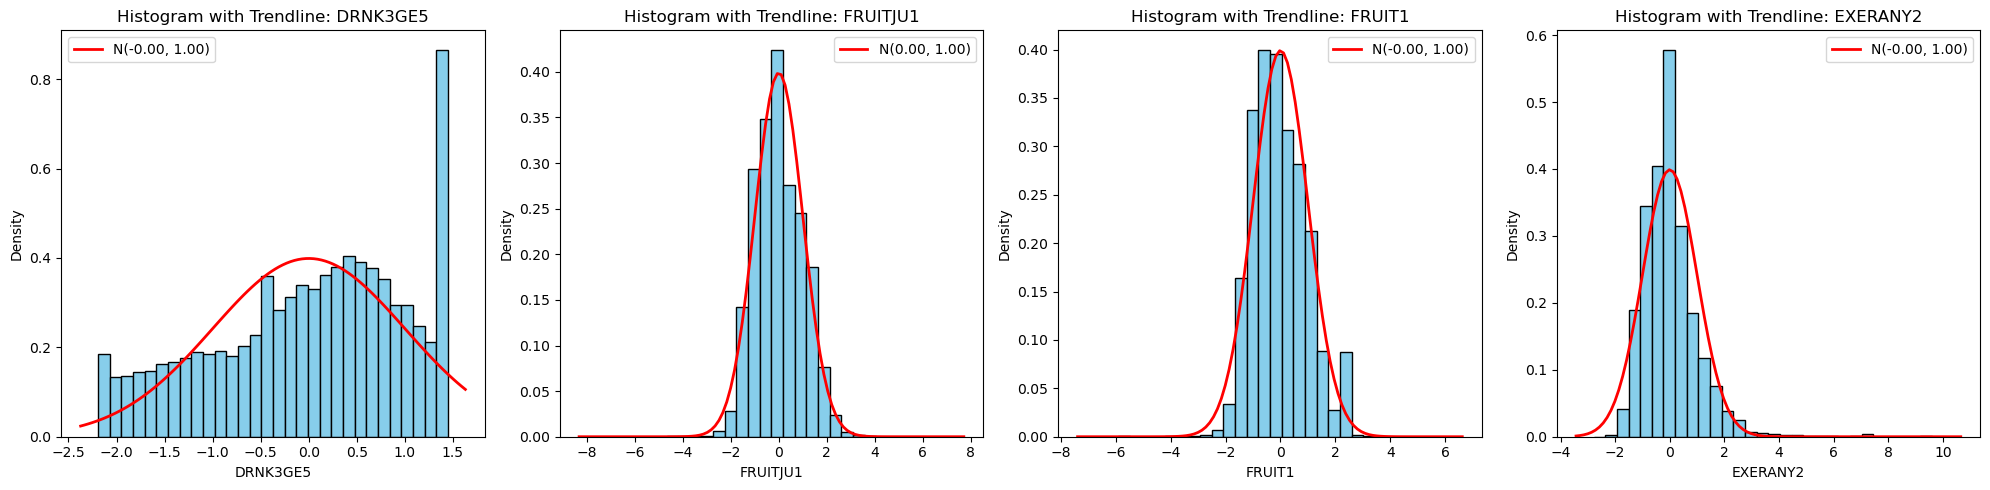

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the indices of these columns
# Select the 1st, 4th, and 5th indices from continuous_features
indices_to_plot = [continuous_features[i] for i in [9,10,11,12]]

# Check if the indices match correctly
print(f"Indices of columns to be plotted: {indices_to_plot}")

# Extract the data for these columns
data_to_plot = x_train_standardized[:, indices_to_plot]

# Get the real column names using new_column_names
columns_to_plot = [new_column_names[i] for i in indices_to_plot]

# Visualize histograms for each column of data and overlay normal distribution trend lines
def plot_histograms_with_trendline(data, column_names, save_path=None):
    num_cols = len(column_names)
    rows = (num_cols + 3) // 4  # Four columns, two rows layout

    fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5))  # Set canvas size

    for i, ax in enumerate(axes.flatten()):
        if i < num_cols:
            # Get data for the current column
            col_data = data[:, i]
            
            # **Modification start: Process col_data**
            col_data = np.squeeze(col_data)        # Ensure it's a 1D array
            col_data = col_data.astype(float)      # Convert to float type
            col_data = col_data[np.isfinite(col_data)]  # Remove NaN and Inf
            # **Modification end**

            # Calculate mean and standard deviation
            mu = np.mean(col_data)
            sigma = np.std(col_data)

            # Plot histogram
            ax.hist(col_data, bins=30, density=True, color='skyblue', edgecolor='black')

            # Generate data for normal distribution curve
            xmin, xmax = ax.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

            # Plot normal distribution curve
            ax.plot(x, y, 'r-', linewidth=2, label=f'N({mu:.2f}, {sigma:.2f})')

            # Set title and labels
            ax.set_title(f"Histogram with Trendline: {column_names[i]}")
            ax.set_xlabel(column_names[i])
            ax.set_ylabel("Density")
            ax.legend()  # Add legend
        else:
            ax.axis('off')  # Hide extra subplots

    plt.tight_layout()

    # If a save path is specified, save the image
    if save_path:
        fig.savefig(save_path) 
        print(f"Image saved as: {save_path}")

    plt.show()

# Plot histograms for specified columns and save as fig1.png
plot_histograms_with_trendline(data_to_plot, columns_to_plot, save_path="fig1.png")


In [15]:
import csv 
# Define function to save data
def save_to_csv(file_path, data, column_names=None):
    """Save data to CSV file"""
    with open(file_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)

        # Write column names if provided
        if column_names:
            writer.writerow(column_names)

        # Write data
        writer.writerows(data)

# Set output path
x_train_encoded_path = "data/dataset/x_train_encoded.csv"
# Set output path
x_test_encoded_path = "data/dataset/x_test_encoded.csv" 

# Save processed dataset to a CSV file
save_to_csv(x_train_encoded_path, x_train_encoded, column_names=new_column_names_train)
# Save processed dataset to a CSV file
save_to_csv(x_test_encoded_path, x_test_encoded, column_names=new_column_names_test)

print(f"Processed dataset has been successfully saved to {x_train_encoded_path}")
print(f"Processed dataset has been successfully saved to {x_test_encoded_path}")

Processed dataset has been successfully saved to data/dataset/x_train_encoded.csv
Processed dataset has been successfully saved to data/dataset/x_test_encoded.csv


This the end of Data Preprocessing.

The following code is to check if the data preprocessing is good enough!

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

data_path = "data/dataset"

# Load label data
y_train_path = f"{data_path}/y_train.csv"
y = np.genfromtxt(y_train_path, delimiter=',', skip_header=1, usecols=1)

X = x_train_encoded # Features

# Use 5% of the dataset for training
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.999, random_state=42)
print(X_train.shape)


(328, 424)


In [18]:

from sklearn.metrics import confusion_matrix, f1_score

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors=1)  # Choose an appropriate k value

# Train the model
knn.fit(X_train, y_train)
# Make predictions on the test set
y_validate_pred = knn.predict(X_validate)

 
accuracy = accuracy_score(y_validate, y_validate_pred)
print(f"Accuracy on the test set: {accuracy:.2%}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_validate, y_validate_pred)
print("Confusion matrix:")
print(conf_matrix)

# Calculate F1 score
f1 = f1_score(y_validate, y_validate_pred, average='weighted')  # Use weighted average
print(f"F1 score: {f1:.2f}")

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_validate, y_validate_pred, target_names=['Class -1', 'Class 1'])
print("Classification report:")
print(report)

Accuracy on the test set: 88.04%
Confusion matrix:
[[285532  13327]
 [ 25881   3067]]
F1 score: 0.87
Classification report:
              precision    recall  f1-score   support

    Class -1       0.92      0.96      0.94    298859
     Class 1       0.19      0.11      0.14     28948

    accuracy                           0.88    327807
   macro avg       0.55      0.53      0.54    327807
weighted avg       0.85      0.88      0.87    327807



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

# Assume X_train, X_test, y_train, y_test are your training and test data

# Create logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Set max_iter to 1000 to ensure convergence

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_validate_pred = log_reg.predict(X_validate)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_validate, y_validate_pred)
print(f"Accuracy on the test set: {accuracy:.2%}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_validate, y_validate_pred)
print("Confusion matrix:")
print(conf_matrix)

# Calculate F1 score
f1 = f1_score(y_validate, y_validate_pred, average='weighted')  # Use weighted average
print(f"F1 score: {f1:.2f}")

# Generate classification report
report = classification_report(y_validate, y_validate_pred, target_names=['Class -1', 'Class 1'])
print("Classification report:")
print(report)

Accuracy on the test set: 87.96%
Confusion matrix:
[[282605  16254]
 [ 23199   5749]]
F1 score: 0.87
Classification report:
              precision    recall  f1-score   support

    Class -1       0.92      0.95      0.93    298859
     Class 1       0.26      0.20      0.23     28948

    accuracy                           0.88    327807
   macro avg       0.59      0.57      0.58    327807
weighted avg       0.87      0.88      0.87    327807



In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

# Assume X_train, X_validate, y_train, y_validate are your training and validation data

# Create SVM model
svm_model = SVC(kernel='linear', C=1.0)  # You can choose different kernel functions like 'rbf', 'poly', etc.

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the validation set
y_validate_pred = svm_model.predict(X_validate)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_validate, y_validate_pred)
print(f"Accuracy on validation set: {accuracy:.2%}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_validate, y_validate_pred)
print("Confusion matrix:")
print(conf_matrix)

# Calculate F1 score
f1 = f1_score(y_validate, y_validate_pred, average='weighted')  # Use weighted average
print(f"F1 score: {f1:.2f}")

# Generate classification report
report = classification_report(y_validate, y_validate_pred, target_names=['Class -1', 'Class 1'])
print("Classification report:")
print(report)

# Accuracy on validation set: 84.79%
# Confusion matrix:
# [[271113  27746]
#  [ 22129   6819]]
# F1 score: 0.85
# Classification report:
#               precision    recall  f1-score   support

#     Class -1       0.92      0.91      0.92    298859
#      Class 1       0.20      0.24      0.21     28948

#     accuracy                           0.85    327807
#    macro avg       0.56      0.57      0.57    327807
# weighted avg       0.86      0.85      0.85    327807



Accuracy on validation set: 84.00%
Confusion matrix:
[[267680  31179]
 [ 21267   7681]]
F1 score: 0.85
Classification report:
              precision    recall  f1-score   support

    Class -1       0.93      0.90      0.91    298859
     Class 1       0.20      0.27      0.23     28948

    accuracy                           0.84    327807
   macro avg       0.56      0.58      0.57    327807
weighted avg       0.86      0.84      0.85    327807



The following code is to implement the regularized logistic regression model, which produced the best performance modle on AIcrowd.

In [ ]:
from implentations import *
# Load data
x_train_pre = np.loadtxt("x_train_processed_0_missing_1029.csv", delimiter=",", skiprows=1)
y_train = np.loadtxt("y_train.csv", delimiter=",", skiprows=1)

# Extract labels
y_train_pre = y_train[:, 1]

x_test_pre = np.loadtxt("x_test_processed_0_missing_1029.csv", delimiter=",", skiprows=1)

# Modify labels, change -1 to 0
y_train_pre[y_train_pre == -1] = 0
y_train_pre = y_train_pre.astype(int)

# Initialize parameters
initial_w = np.zeros(x_train_pre.shape[1])  # Initialize weights to zero vector
max_iters = 1000  # Maximum number of iterations
gamma = 0.01  # Learning rate
lambda_ = 0.1  # Regularization strength
batch_size = 64  # Batch size

# Train the regularized logistic regression model
w, loss = logistic_regression(y_train_pre, x_train_pre, initial_w, max_iters, gamma, lambda_, batch_size)
print(f"Final loss after training: {loss}")

# Load Id column from sample-submission
sample_submission = np.loadtxt('sample-submission.csv', delimiter=',', skiprows=1, usecols=0, dtype=int)

# Predict on the test set
y_pred = predict(x_test_pre, w)

import csv 
# Define function to save data
def save_to_csv(file_path, data, column_names=None):
    """Save data to CSV file"""
    with open(file_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)

        # Write column names if provided
        if column_names:
            writer.writerow(column_names)

        # Write data
        writer.writerows(data)

# Set output path
sample-submission_path = "data/dataset/sample-submission.csv"
# Save processed dataset to a CSV file
save_to_csv(sample-submission_path, column_names=new_column_names_test)
print(f"Processed dataset has been successfully saved to {sample-submission_path}")